In [1]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [42]:
file_path = '../Features/rabbit_B_SHAP_DT.xlsx'
df = pd.read_excel(file_path)
df.head()

,BertzCT,HallKierAlpha,NOCount,EState_VSA3,VSA_EState8,MinPartialCharge,PEOE_VSA1,FpDensityMorgan3,PEOE_VSA9,Irritation
0,0.089220,0.511069,0.182574,0.000000,0.256948,0.574868,0.196324,0.595823,0.000000,1
1,0.146317,0.462893,0.258199,0.232360,0.212267,0.684832,0.178444,0.743926,0.230156,1
2,0.496390,0.283431,0.365148,0.385749,0.047926,0.627533,0.261267,0.695162,0.361580,0
3,0.435679,0.295994,0.483046,0.216291,0.000000,0.683098,0.315318,0.700246,0.385121,0
4,0.402744,0.361936,0.447214,0.290634,0.261484,0.579127,0.189052,0.651106,0.205850,0


In [41]:
df.shape

(857, 10)

In [39]:
df.columns.to_list()

['BertzCT',
 'HallKierAlpha',
 'NOCount',
 'EState_VSA3',
 'VSA_EState8',
 'MinPartialCharge',
 'PEOE_VSA1',
 'FpDensityMorgan3',
 'PEOE_VSA9',
 'Irritation']

In [43]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [45]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (685, 9)
Shape of X_test: (172, 9)
Shape of y_train: (685,)
Shape of y_test: (172,)


In [58]:

def objective(trial):
    # Define hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]), 
        "max_depth": trial.suggest_int("max_depth", 5, 15),  
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 15),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2", 0.3, 0.5]), 
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 20),  
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.05),  
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),  
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),  
    }

    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = DecisionTreeClassifier(**params) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best parameters:", study.best_trial.params)

# Train final Decision Tree model with best parameters
best_params = study.best_trial.params
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-04-30 13:26:25,704] A new study created in memory with name: no-name-d5b2d737-4b3e-4448-bf24-f44cd66b2178
[I 2025-04-30 13:26:25,880] Trial 0 finished with value: 0.6452554744525547 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'max_leaf_nodes': 13, 'min_impurity_decrease': 0.031184679662626447, 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6452554744525547.
[I 2025-04-30 13:26:25,889] Trial 1 finished with value: 0.6934306569343065 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 0.3, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.04686141145264043, 'splitter': 'best', 'class_weight': None}. Best is trial 1 with value: 0.6934306569343065.
[I 2025-04-30 13:26:25,907] Trial 2 finished with value: 0.7532846715328467 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split':

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': None, 'max_leaf_nodes': 18, 'min_impurity_decrease': 0.0026520813228915123, 'splitter': 'random', 'class_weight': None}
Final Model Accuracy: 0.8081395348837209


In [59]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the Decision Tree model
    final_model = DecisionTreeClassifier(**best_params)


    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.778978102189781 0.7662790697674419


In [60]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Get best hyperparameters from Optuna study
best_params = study.best_trial.params
# Initialize the Decision Tree model
final_model = DecisionTreeClassifier(**best_params)

# Fit the model
final_model.fit(X_train, y_train)
print("Train Accuracy:", final_model.score(X_train, y_train))
print("Test Accuracy:", final_model.score(X_test, y_test))

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Train Accuracy: 0.7912408759124088
Test Accuracy: 0.7790697674418605
Precision: 0.7428571428571429
Recall: 0.7222222222222222
F1 Score: 0.7323943661971831


Final Model Accuracy on Test: 0.6918604651162791


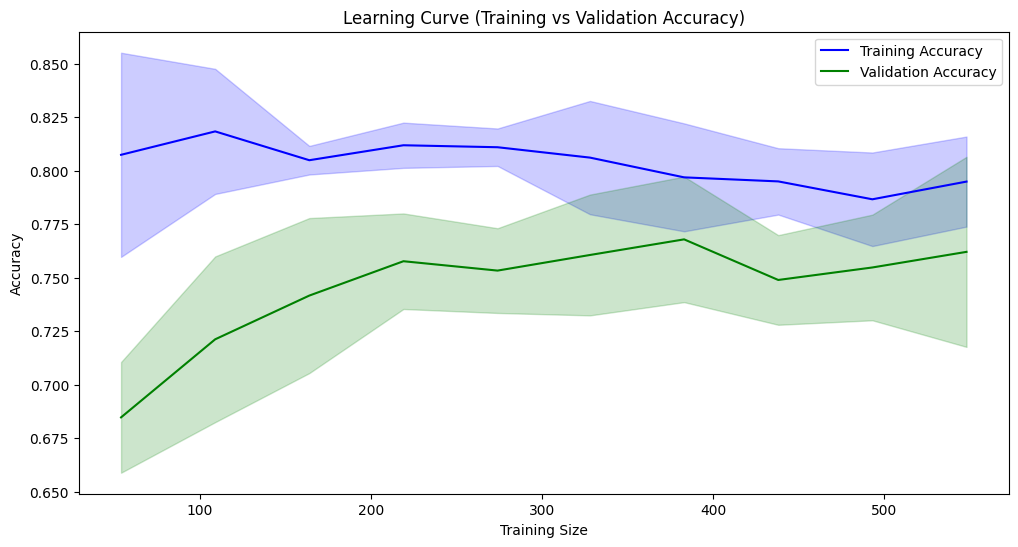

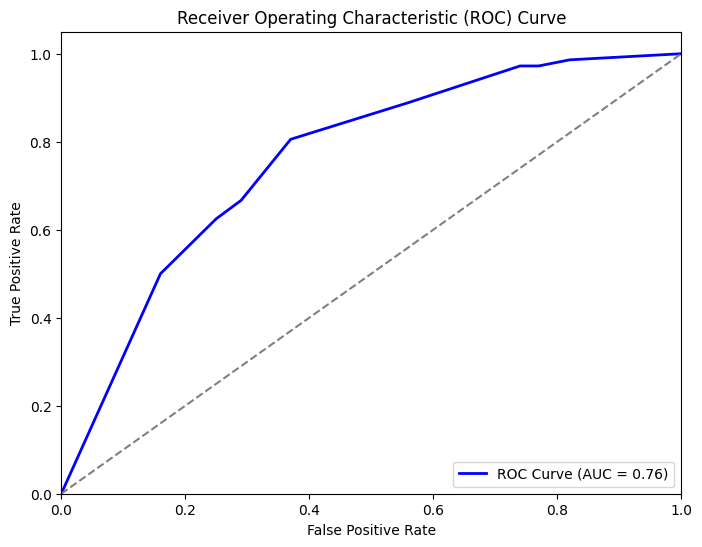

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve

# Get best hyperparameters from Optuna study
best_params = study.best_trial.params
best_params.pop("use_max_leaf_nodes", None)  # Remove invalid key

# Initialize the Decision Tree model
final_model = DecisionTreeClassifier(**best_params)

# Fit the model
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))


# Compute learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Ensure model supports predict_proba (classification case)
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve cannot be plotted. Model does not support probability predictions.")


In [65]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train)

In [ ]:
import joblib

joblib.dump(final_model, 'dt_model.pkl')

print("Model saved successfully!")
